In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import root_pandas as rp
from scipy.special import factorial
from scipy.optimize import curve_fit
from lmfit import Model
from corner import corner

Welcome to JupyROOT 6.18/04


In [2]:
data = rp.read_root("/Users/tylern/Data/ntuple/ntuple.root")

In [3]:
data = data[(data.W > 0.0) & (data.W < 1.8) & (data.type == 0)]
data = data.dropna()
data.head()

,type,helicity,W,Q2,MM,MM2,Theta_E,Theta_star,Phi_star,theta,phi,sector
14,0,0,1.559701,1.775957,1.124512,1.264527,1.908076,0.044239,5.218319,20.042803,-141.383209,5
26,0,0,1.329068,2.465088,0.944906,0.892848,2.205863,0.624860,0.031104,23.709200,93.886337,1
36,0,0,1.514696,1.700592,0.947070,0.896941,1.907853,1.557060,4.653820,19.248316,-157.883011,5
37,0,0,1.722912,2.814058,1.194385,1.426556,2.137826,1.955923,3.473066,29.826731,-22.634338,3
135,0,-1,1.478799,2.190753,0.964287,0.929849,2.066249,1.343871,2.447713,22.629248,-96.213997,4


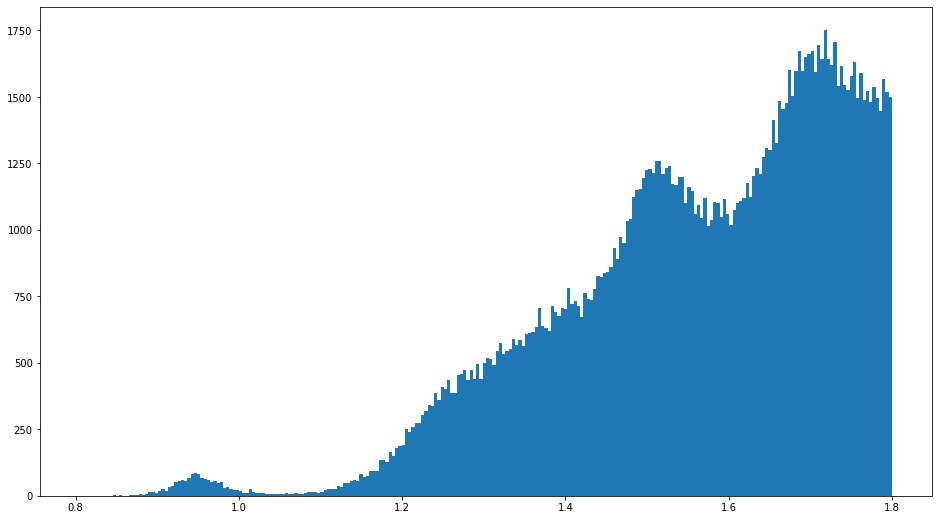

In [4]:
fig = plt.figure(figsize=(16,9))
plt.hist(data.W, bins=250)
plt.show()

In [5]:
def gaus_fit(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def poly_fit(x, d, e, f):
    poly = d + e*x + f*x**2
    return poly
  
def bw(x, A, M, Gamma):
    g = np.sqrt((np.power(M,2)+np.power(Gamma,2)) * np.power(M,2))
    k = (2*np.sqrt(2)*M*Gamma*g)/(np.pi * np.sqrt(np.power(M,2) + g) )
    f = A*k/(np.power((np.power(x,2) - np.power(M,2)),2 + np.power(M,2)*np.power(Gamma,2)))
    f = np.nan_to_num(f)
    return f
    
def gaus_poly(x, A, mu, sig, d, e, f):
    gaus = gaus_fit(x, A, mu, sig)
    poly = poly_fit(x, d, e, f)
    return gaus + poly

def double_gaus(x, A, mu, sig, A_bck, mu_bck, sig_bck):
    gaus = gaus_fit(x, A, mu, sig)
    gaus_bck = gaus_fit(x, A_bck, mu_bck, sig_bck)
    return gaus + gaus_bck

def plot_mm_N(data, bins=200, range=(0.88, 1.15)):
    fig = plt.figure(figsize=(16,9))    
    ys,xs = np.histogram(data, range=range, bins=bins, density=True)
    xs = (xs[:-1]+xs[1:])/2.0
 
    mod = Model(double_gaus)
    pars = mod.make_params(A=np.max(ys), mu=0.93, sig=1.5E-2, A_bck=2.0, mu_bck=1.0, sig_bck=1.5)
    
    mod.set_param_hint("mu", value=0.9, vary=1E-4, min=0.7, max=1.05)
    mod.set_param_hint("mu_bck", value=1.0, vary=1E-5, min=0.95, max=1.5)
    
    
    emcee_kws = dict(steps=10000, burn=300, thin=20, is_weighted=False, progress=True)
    result = mod.fit(ys, pars,method='emcee', x=xs, fit_kws=emcee_kws)
    plt.plot(xs, result.best_fit, 'r-', 
             label=f"double gaus lmfit:\t$\mu = $ {result.best_values['mu']:0.4f}   $\sigma =$ {result.best_values['sig']:0.4f}")

    g_params, g_covariance = curve_fit(gaus_fit, xs, ys, 
                                       p0=[np.max(ys), 0.93, 1.5E-2], maxfev = 8000)

    x = np.linspace(np.min(xs), np.max(xs),200)
    gp_params, gp_covariance = curve_fit(gaus_poly, xs, ys, 
                                         p0=[*g_params, 1.0, 1.0,1.0], maxfev = 8000)
    
    
    plt.errorbar(xs, ys, yerr=np.std(ys)/100, fmt='.')
    #plt.plot(x, gaus_fit(x,*g_params), 
    #         label=f"gaus curve_fit:\t\t$\mu = $ {g_params[1]:0.4f}   $\sigma =$ {g_params[2]:0.4f}")
    #plt.plot(x, gaus_fit(x,*gp_params[0:3]))
    #plt.plot(x, poly_fit(x,*gp_params[3:]))
    #plt.plot(x, gaus_poly(x,*gp_params),
    #        label=f"gaus poly curve_fit:\t$\mu = $ {gp_params[1]:0.4f}   $\sigma =$ {gp_params[2]:0.4f}")
    plt.legend(loc='best')
    
    #_min = gp_params[1]-3*gp_params[2]
    #_max = gp_params[1]+3*gp_params[2]
    _min = result.best_values['mu']-3*result.best_values['sig']
    _max = result.best_values['mu']+3*result.best_values['sig']
             
    plt.axvline(_min, 0, 10)
    plt.axvline(_max, 0, 10)

    
    plt.show()
             
    corner(result.flatchain, labels=result.var_names)
             
    return _min, _max

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


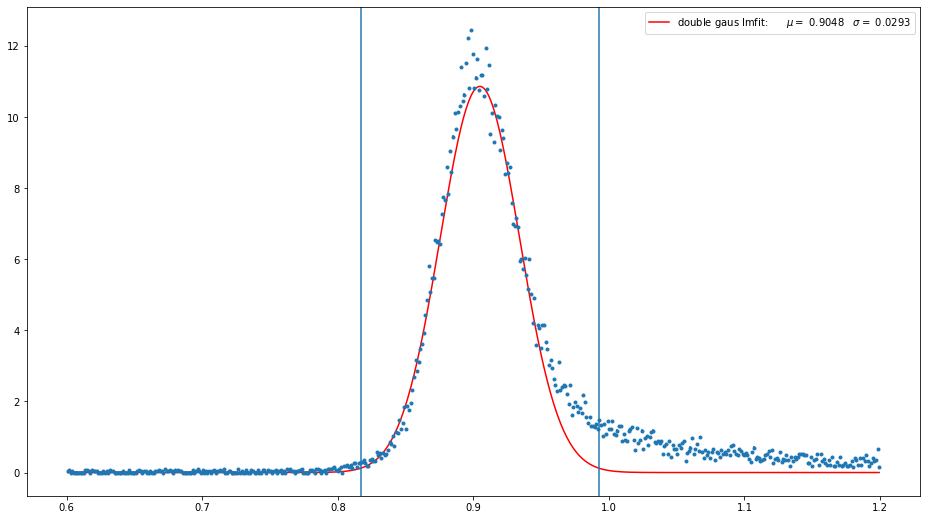

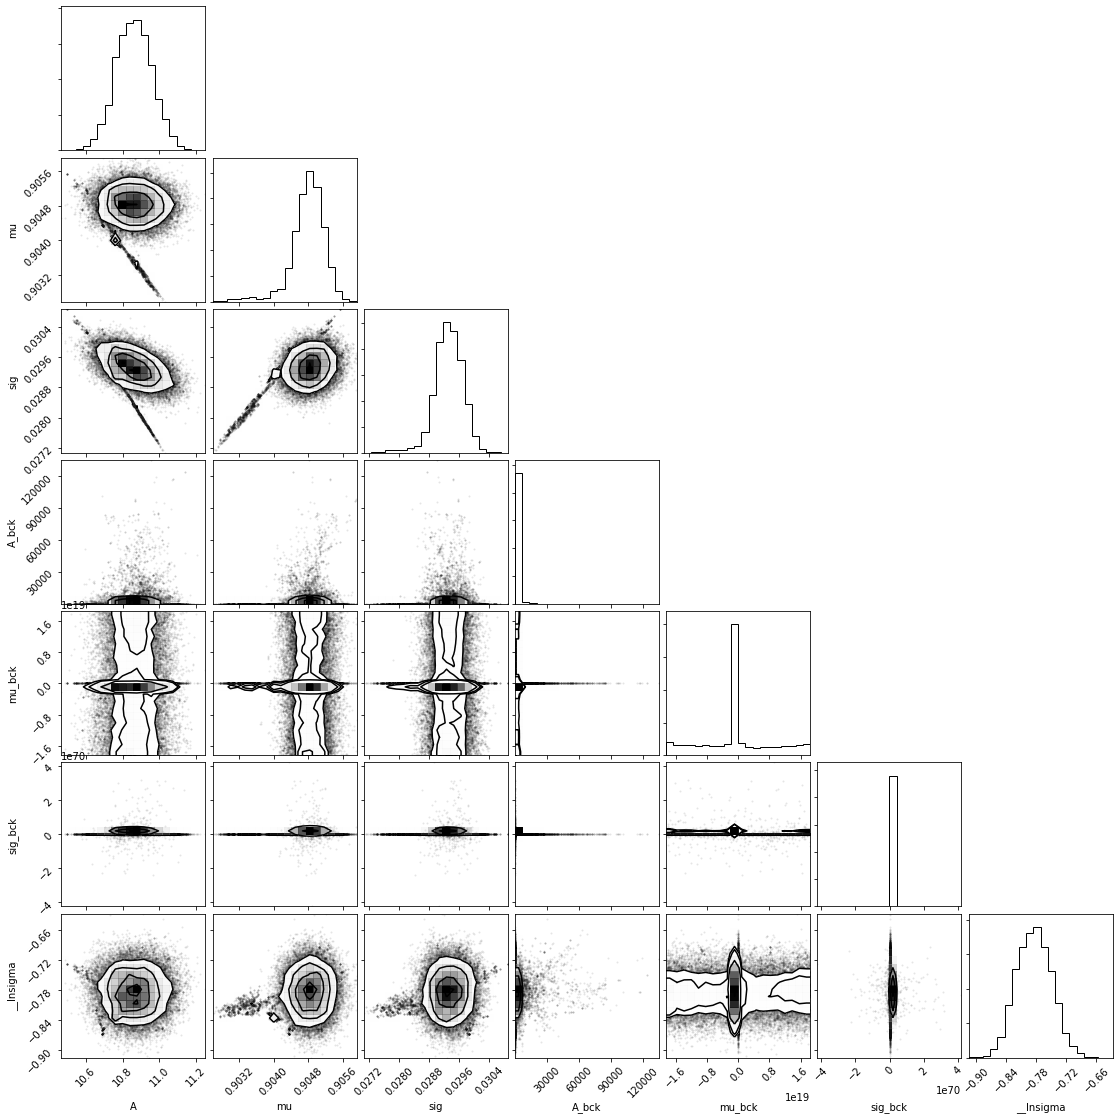

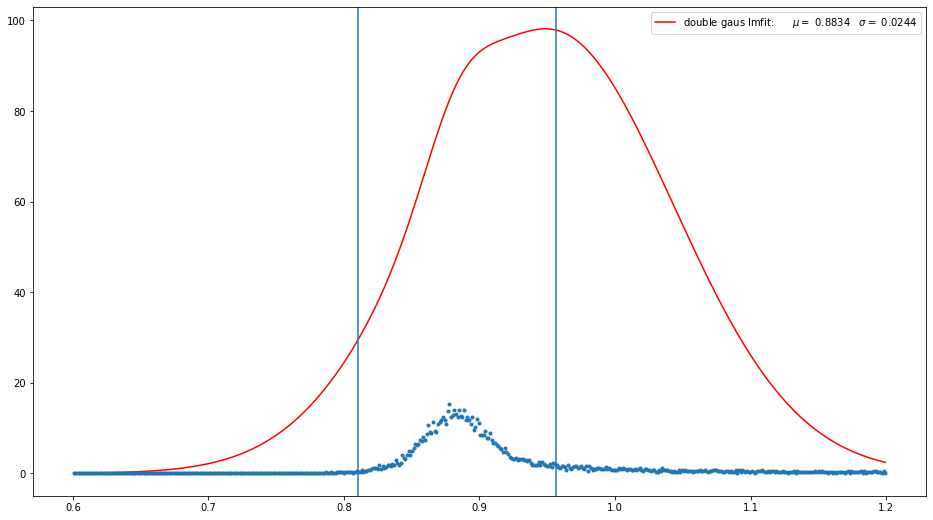

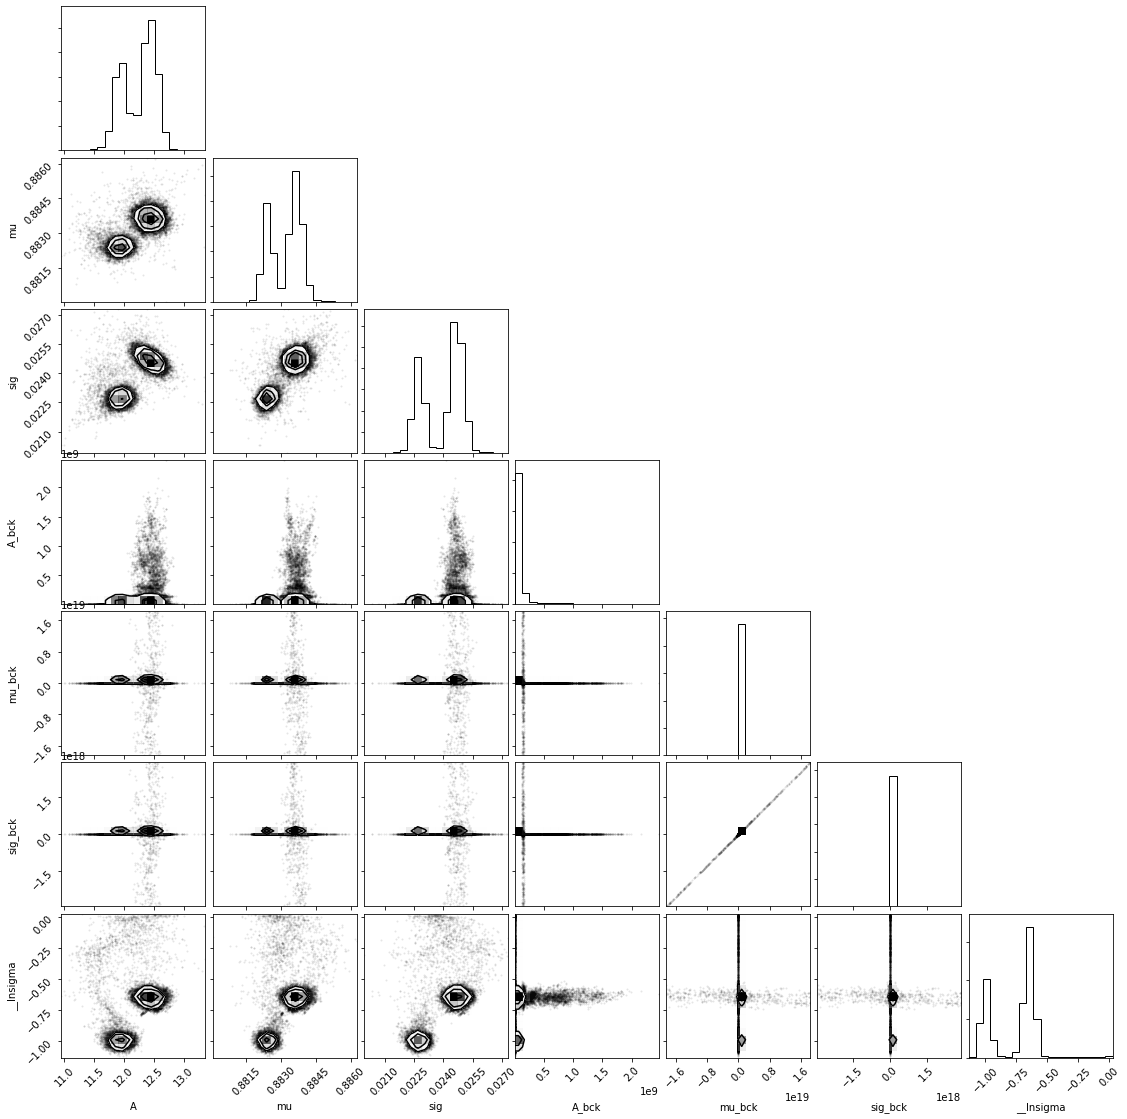

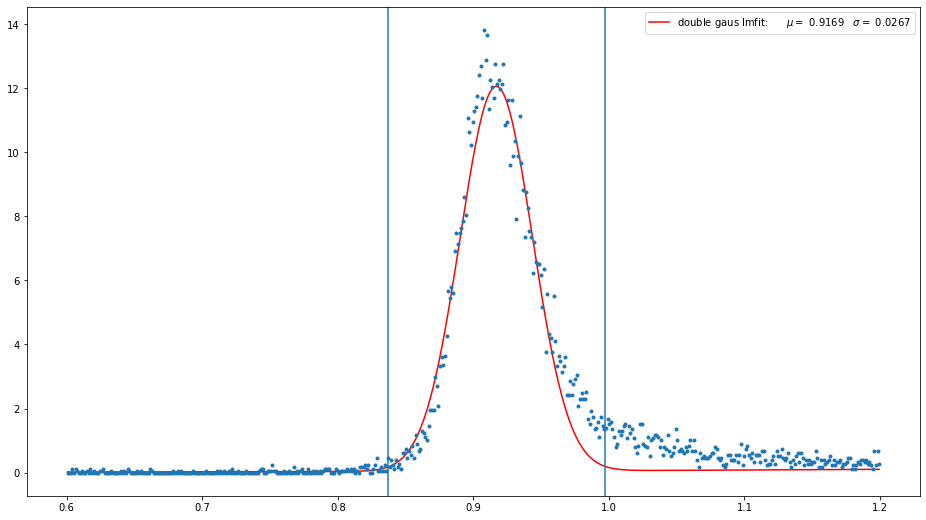

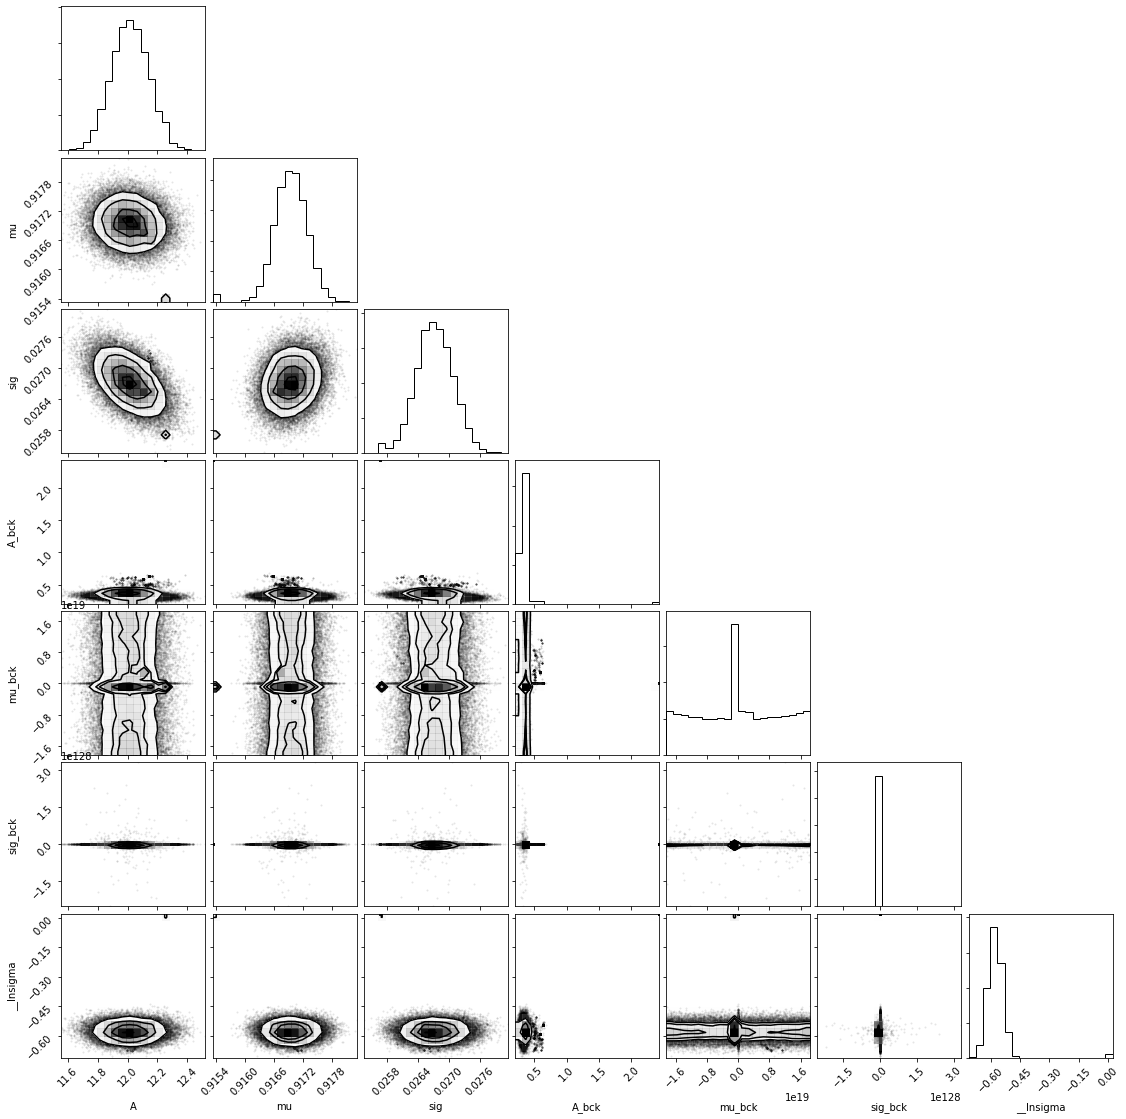

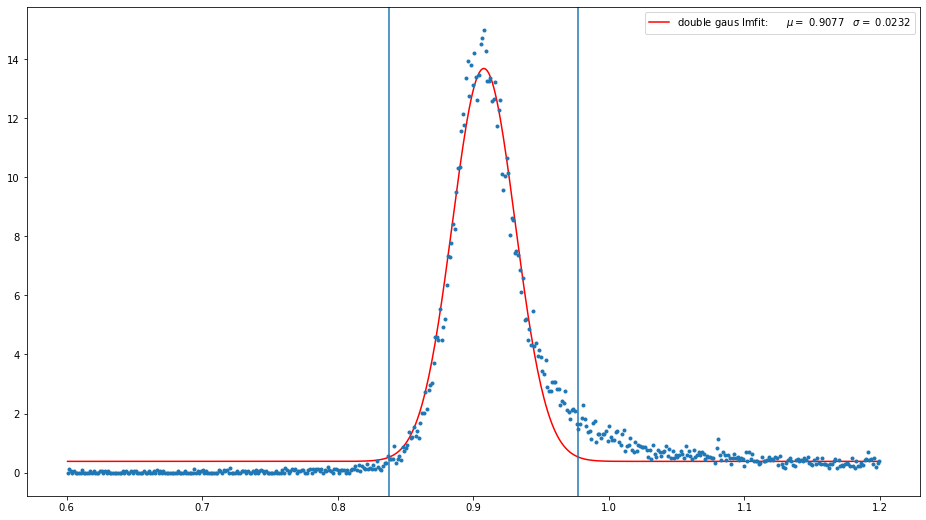

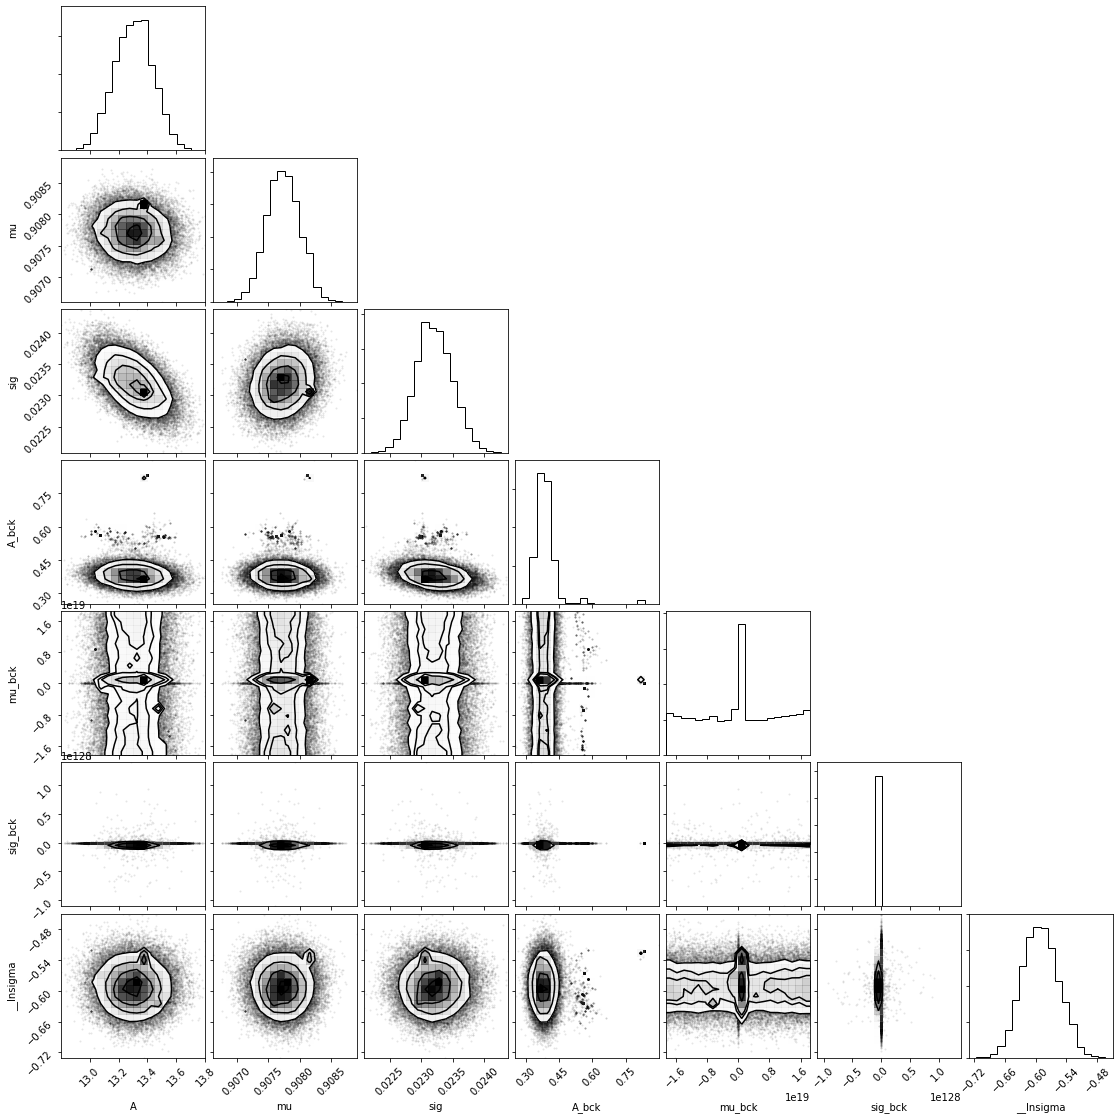

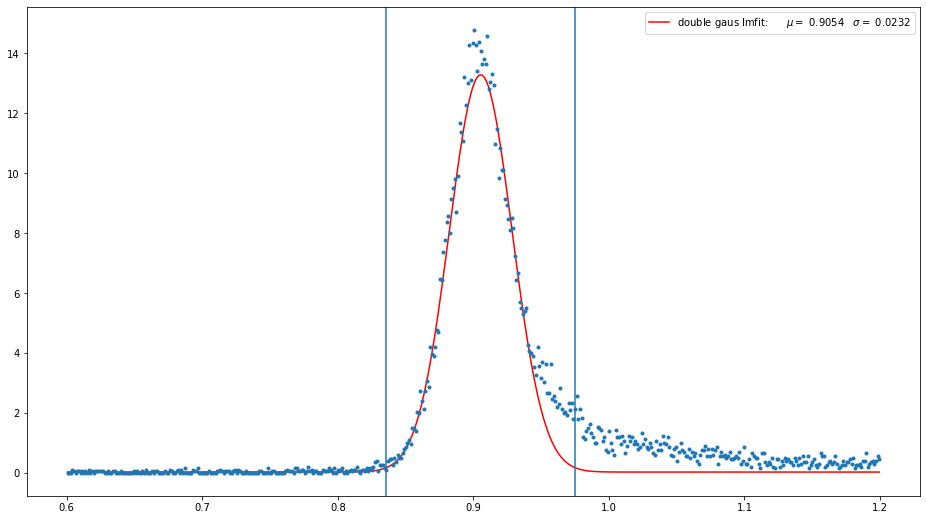

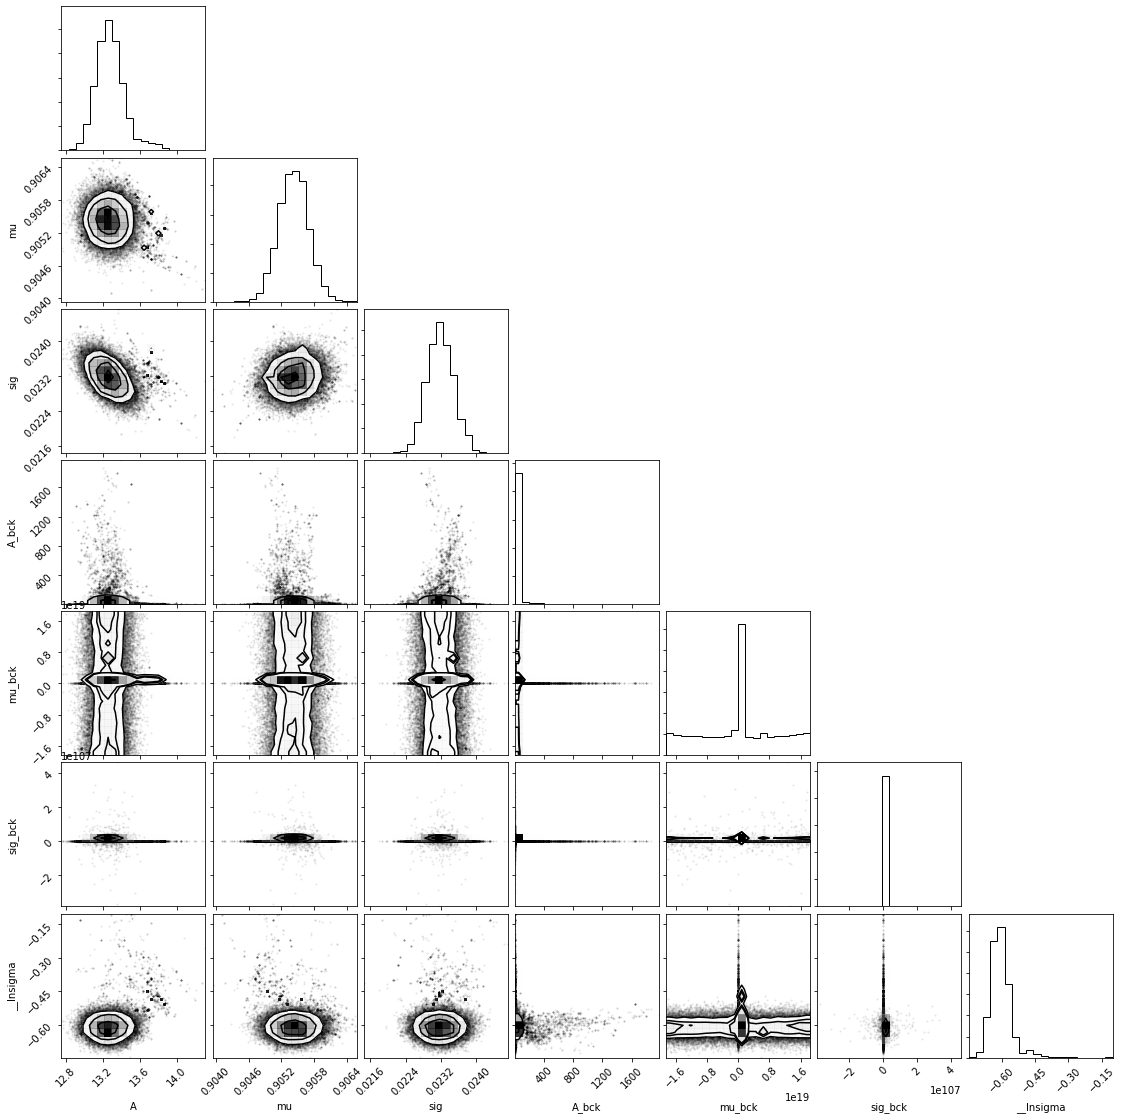

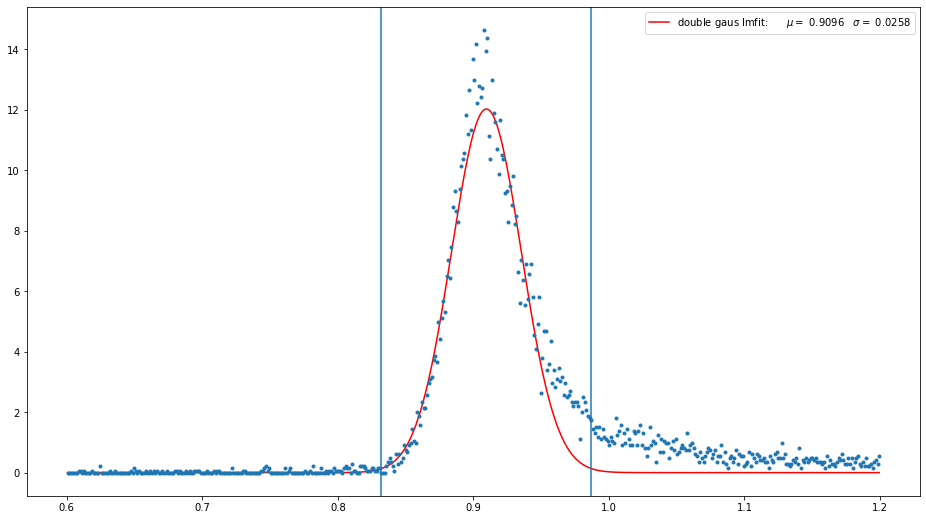

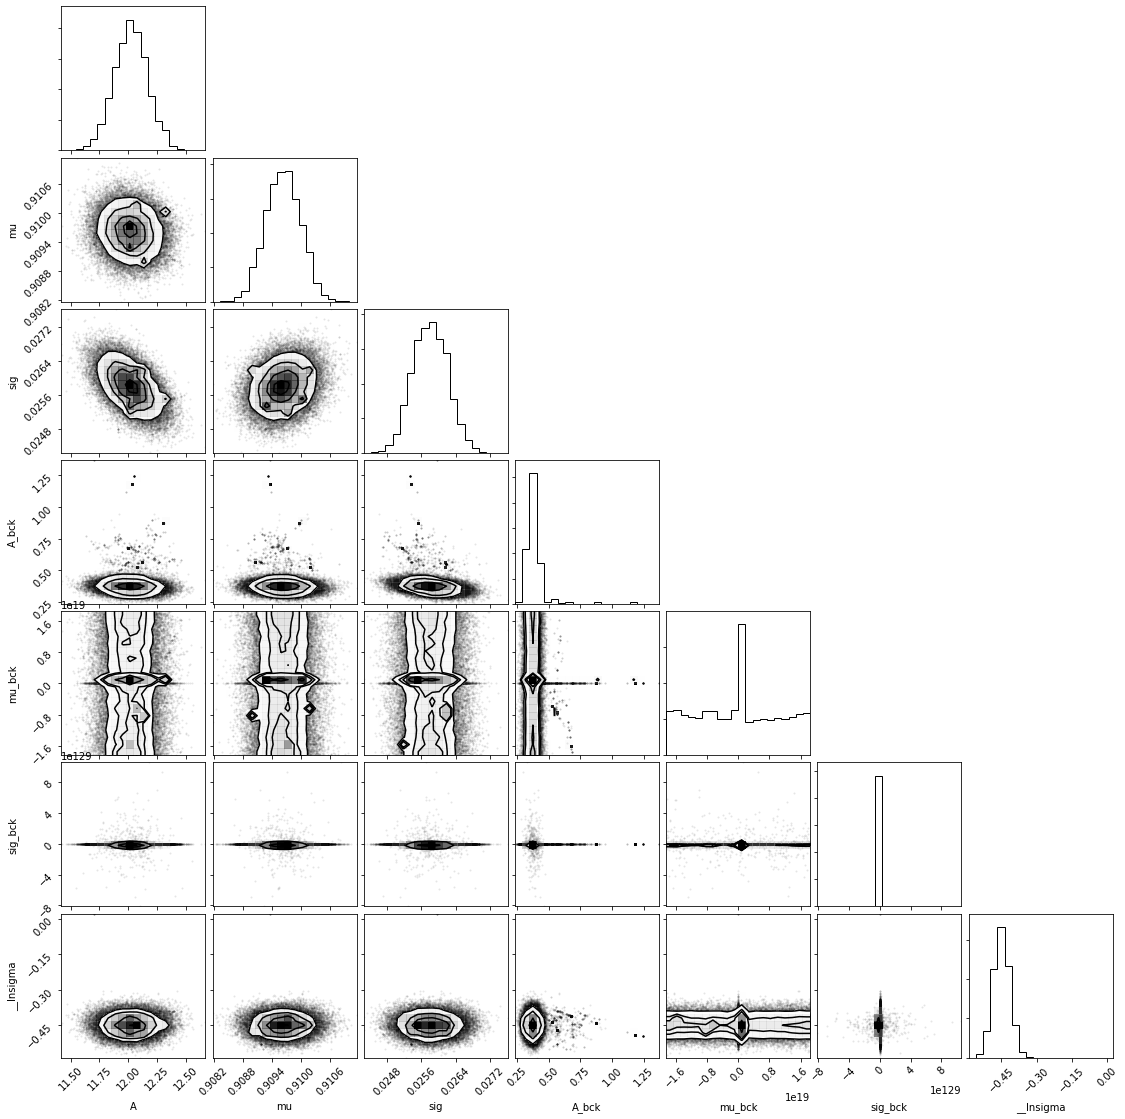

In [6]:
mm_sec_cut = []
for sec in range(1,7):
    cuts = plot_mm_N(data[data.sector == sec].MM2, bins=500, range=(0.7, 1.2))
    mm_sec_cut.append([sec, cuts[0], cuts[1]])
    

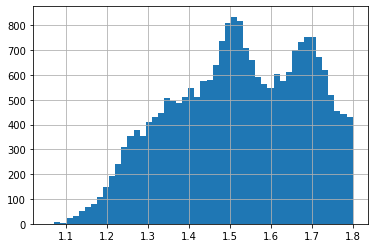

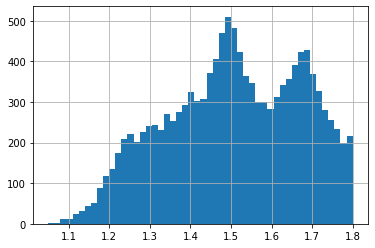

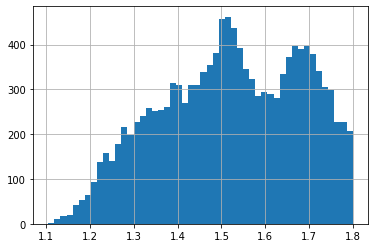

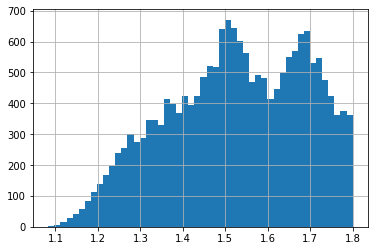

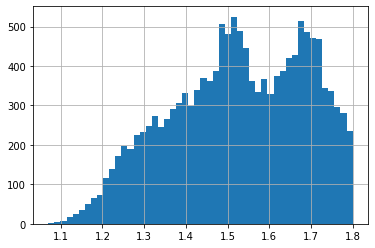

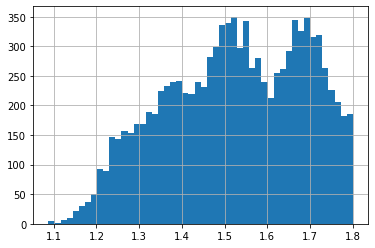

In [7]:
for sec, _min, _max in mm_sec_cut:
    data[(data.sector == sec) & (data.MM2 >= _min) & (data.MM2 <= _max)].W.hist(bins=50)
    plt.show()